# HACKtheMACHINE 2021 | Track 2: Data Science, Detective Bot 

The following data dictionary describes the columns or fields of the data set and a description of the objects. This information with more detail can also be found in the `EMBER` documentation of the `features.py` file at: https://github.com/elastic/ember/blob/master/ember/features.py 

| Field Name | Description | 
|------------|-------------|
| sha256 | The Secure Hash Algorithm (SHA) is a cryptographic hash function like a signature or fingerprints for a data set. Even if one symbol is changed the algorithm will produce a different hash value. The SHA256 algorithm generates a fixed size 256-bit (32-byte) hash. The SHA256 algorithm is used to ensure you acquire the same data as the original. For exmaple, if you download something you can check if the data has not changed (due to network errors or malware injection) by comparing the hashes of your file and the original.|
| histogram | Byte histogram (count + non-normalized) over the entire binary file. The byte histogram contains 256 integer values and represent the counts of each byte value within the value. When generating model features the byte histgoram is normalized to a distribution, since file size is represented as a feature in the general file information. | 
| byteentropy | 2D byte/entropy histogram based loosely on (Saxe and Berlin, 2015). This roughly approximates the joint probability of byte value and local entropy. See Section 2.1.1 in https://arxiv.org/pdf/1508.03096.pdf for more info. The byte entropy histogram approximates the joint distriubtion p(H, X) of entropy H and byte value X. By computing the scalar entropy H for a fixed-length window and pairing it with each byte occurrence within the window. This is repeated as the window slides across the input bytes. |
| strings | Contains simple statistics about printable strings of the following: <ul><li>`numstrings`: number of strings <li> `avlength`: average length of strings <li>`printabledist`: histogram of the printable characters within those strings <li>`printables`: distinct information from byte histogram information from the byte histogram information since its derived only from strings containing at least 5 consecutive printable characters <li>`entropy`: entropy of characters across all printable strings <li>`paths` number of strings that begin with **C:** (case insensitive) that may indicate a path <li>`urls`: the number of occurences of **http://** or **https://** (case insensitive) that may indicate a URL <li>`registry`: number of occurrences of HKEY that may indicate a registry key, <li>`MZ`: number of occurrences of the short string MZ |
| general | Provides general file information. 0/1 indicates a binary output <ul><li>`size`: length of bytes <li>`vsize`: virtual size <li>`has_debug`: 0/1  <li>`exports`: 0/1 <li>`imports`: 0/1 <li>`has_relocations`: 0/1  <li>`has_resources`: 0/1 <li>`has_signature`: 0/1 <li>`has_tls`: 0/1 <li>`symbols`: 0/1 |
| header | Provides header file information on machine, architecture, OS, link and other information: <ul><li> `coeff`: [ `timestamp`, `machine`,`characteristics` ] <li> `optional`: [`subsystem`, `dll_characteristics`, `magic`, `major_image_version`, `minor_linker_version`, `major_operating_system_version`, `minor_operating_system_version`, `major_subsystem_version`, `minor_subsystem_version`, `sizeof_code`, `sizeof_headers`, `sizeof_heap_commit`]
| section | Information about section names, sizes and entropy. Uses hashing trick to summarize all this section into a feature vector. <ul><li> `imports`: [`KERNEL32.dll` : [`GetTickCount`] | 
| imports | Information about imported libraries and functions from the import address table. Note that the total number of imported functions is contained in GeneralFileInfo. |
| exports | Information about exported functions. Note that the total number of exported functions is contained in GeneralFileInfo.|
| datadirectories | Extracts size and virtual address of the first 15 data dictectories. |
| label / category | Class label indicating benign `0` or malicious `1`|

## Load Libraries

In [1]:
import numpy as np #data manipulation
import pandas as pd #data manipulation
import sklearn as sk #modeling & metrics
import seaborn as sns #visualizations
import scipy as stats #visualizations
from matplotlib import pyplot as plt #visualizations

#imputation, scaling, metrics
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import resample
from sklearn.metrics import r2_score, classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression

#outlier classification
from sklearn.ensemble import IsolationForest

import xgboost as xgb #xgb model
import lightgbm as lgb
import hyperopt #hyperparameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import shap #shap plot

import pickle 
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install git+https://github.com/elastic/ember.git

In [3]:
import Ember_Wrapper

## Requirements

The requirements file is this output copy pasted into a txt file.

In [4]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.21.2
pandas==1.3.4
sklearn==1.0.1
seaborn==0.11.2
scipy==1.6.0
xgboost==1.5.0
lightgbm==3.2.1
hyperopt==0.2.5
shap==0.40.0


## Load Data

In [5]:
# Flattened EMBER Feature set
# Easier to feed into ML models right away
# df1 = pd.read_excel("flatten_train.xlsx")

Use pickling so you don't have to read in the Excel file every time to resume progress.

In [6]:
# pd.to_pickle(df1, "./data.pkl")

In [7]:
df1 = pd.read_pickle("./data.pkl")

In [8]:
df2 = pd.read_excel("./Data/raw_train.xlsx")

Checking number of malware entries.

In [9]:
sum(df1['category'])

900

In [10]:
df1.shape

(18000, 714)

In [11]:
900/18000

0.05

5%, super imbalanced.

## EDA

### Visualizations Team here:
### try plotting distributions of certain features to compare them between the malware and not malware tables

In [12]:
df1.head(5)

,sha256,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,...,datadirectories_13_name,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_name,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_name,datadirectories_15_size,datadirectories_15_virtual_address,category
0,15f88c44e29e74965cbec984cd4244786eeb4ccde02328...,127242,9185,3818,3127,13300,1594,1781,1493,9938,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
1,29bb2a854de0f99bdb7120870ad42af6a3b5b5c6fc3578...,36152,2617,4120,876,1711,755,672,521,2278,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
2,5cd8667d8375bf799fe89ac9b74cf08bf69dfa18a4e551...,39986,7112,7953,6604,6542,6441,5869,6422,6224,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
3,ce63706c0adf4851a8d2eb26fa97750cfaec7345151367...,253873,32714,22629,17500,15355,6691,10881,4258,11992,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
4,5e65dd9986fc47c5fe45208fab5e1c78730699800eaf96...,12464,1020,502,264,1918,218,262,91,846,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0


In [13]:
list(df1)

['sha256',
 'histogram_0',
 'histogram_1',
 'histogram_2',
 'histogram_3',
 'histogram_4',
 'histogram_5',
 'histogram_6',
 'histogram_7',
 'histogram_8',
 'histogram_9',
 'histogram_10',
 'histogram_11',
 'histogram_12',
 'histogram_13',
 'histogram_14',
 'histogram_15',
 'histogram_16',
 'histogram_17',
 'histogram_18',
 'histogram_19',
 'histogram_20',
 'histogram_21',
 'histogram_22',
 'histogram_23',
 'histogram_24',
 'histogram_25',
 'histogram_26',
 'histogram_27',
 'histogram_28',
 'histogram_29',
 'histogram_30',
 'histogram_31',
 'histogram_32',
 'histogram_33',
 'histogram_34',
 'histogram_35',
 'histogram_36',
 'histogram_37',
 'histogram_38',
 'histogram_39',
 'histogram_40',
 'histogram_41',
 'histogram_42',
 'histogram_43',
 'histogram_44',
 'histogram_45',
 'histogram_46',
 'histogram_47',
 'histogram_48',
 'histogram_49',
 'histogram_50',
 'histogram_51',
 'histogram_52',
 'histogram_53',
 'histogram_54',
 'histogram_55',
 'histogram_56',
 'histogram_57',
 'histogram_5

In [14]:
malware = df1[df1['category'] == 1]
not_malware = df1[df1['category'] == 0]

In [15]:
def dist_plotter(feature_name): #random function, make some more
    fig, ax = plt.subplots(2,1)
#     ax.set(ylabel='common ylabel', title=feature_name)
    sns.violinplot(malware[feature_name], inner="quartile", ax=ax[0], color='r')
    sns.violinplot(not_malware[feature_name], inner="quartile", ax=ax[1], color='r')

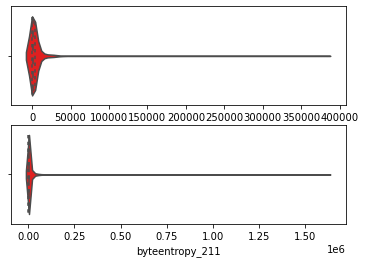

In [16]:
dist_plotter('byteentropy_211')

## Undersampling

Since only 5% of entries are malware, we want a similar 50/50 split between malware and not malware. Could also use SMOTE.

In [17]:
majority = df2[df2.category==0] # Majority class
minority = df2[df2.category==1] # Minority class

In [18]:
majority_undersampled = resample(majority, replace=False, n_samples=900) # Randomly selects 900 records from majority to match minority class size
# New downsampled dataset
df_undersampled = pd.concat([majority_undersampled, minority])  # Minority class + sample of 900 from majority
df_undersampled.category.value_counts()

0    900
1    900
Name: category, dtype: int64

In [19]:
Ember_Wrapper.create_vectorize_features(df_undersampled)

In [20]:
X = np.load('./X_data.npy')
y = np.load('./y_data.npy')
print('X.shape', X.shape)
print('%Malware:', sum(y) / len(y))

X.shape (1800, 2381)
%Malware: 0.5


In [21]:
# df = df_undersampled #make it a new df

In [22]:
# X = df.drop('category', axis=1) #X is everything but the 'category' col

In [23]:
# y = df['category'] #y is just the target column

In [24]:
# X = X._get_numeric_data() #drop all nonnumeric ones (for now?)

In [25]:
# print(X.shape, y.shape) #sanity check arrays

## Feature Selection with ANOVA

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #train test split 80/20

Ideally should select features after heatmaps/correlation plots/distributions etc but skipped for now.

This is automatic but more of a "black box".

PCA would also go here.

In [27]:
fs = SelectKBest(score_func=f_classif, k=600) #THIS K IS HOW MANY FEATURES YOU WANT
fs.fit(X_train, y_train)
mask = fs.get_support()
new_features = X_train.columns[mask]

In [28]:
# X_train_fs = X_train[new_features]
# X_test_fs = X_test[new_features]

In [29]:
X_train_fs = X_train
X_test_fs = X_test

In [30]:
# for i in range(len(fs.scores_[:10])):
#     print('Feature %d: %f' % (i, fs.scores_[i]))
# # plot the scores
#     plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
#     plt.show()

Now we can use X_train_fs and X_test_fs in place of X_train and X_test.

In [31]:
print(X_train_fs.shape, X_test_fs.shape)

(1440, 2381) (360, 2381)


In [32]:
print(y_train.shape, y_test.shape)

(1440,) (360,)


## Modeling

This function basically fits a specified model and outputs it's f1_score as well as ROC curve, can add more graphs/plots to it as well.

In [33]:
def modeler(model):
    model.fit(X_train_fs, y_train) #fit specified model
    y_pred = model.predict(X_test_fs) #predict on test set
    f1 = f1_score(y_test, y_pred) #get f1 score
    print('F1 Score:', f1)
    print(metrics.confusion_matrix(y_test, y_pred))
    
    #this plots the ROC curve, play around iwth it
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

F1 Score: 0.7328605200945627
[[ 92  81]
 [ 32 155]]


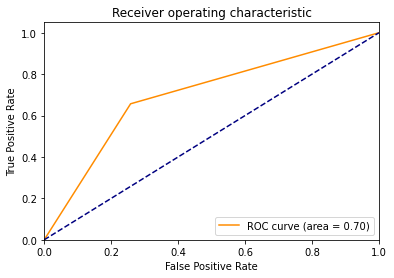

In [34]:
lr = LogisticRegression()
modeler(lr)

F1 Score: 0.946524064171123
[[163  10]
 [ 10 177]]


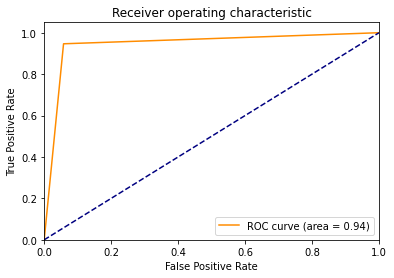

In [35]:
lgbm = lgb.LGBMClassifier()
modeler(lgbm)

F1 Score: 0.924731182795699
[[160  13]
 [ 15 172]]


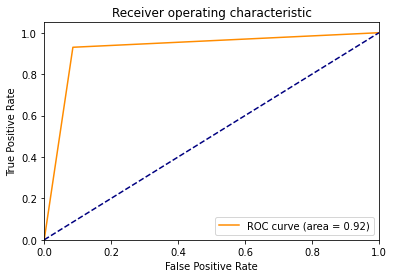

In [36]:
xgbc = xgb.XGBClassifier(eval_metric='logloss')
modeler(xgbc)

F1 Score: 0.8907103825136612
[[157  16]
 [ 24 163]]


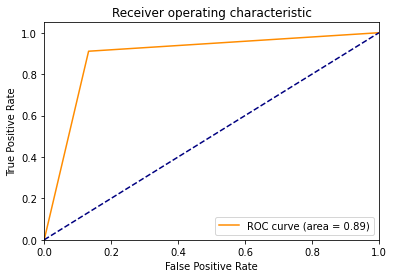

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
modeler(rf)

F1 Score: 0.19469026548672566
[[156  17]
 [165  22]]


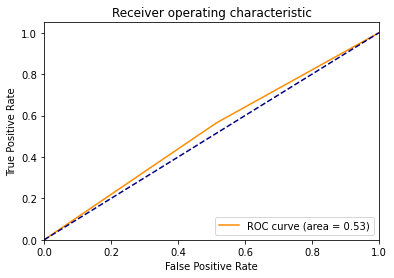

In [38]:
from sklearn.svm import SVC
svm = SVC()
modeler(svm)

F1 Score: 0.7238605898123325
[[122  51]
 [ 52 135]]


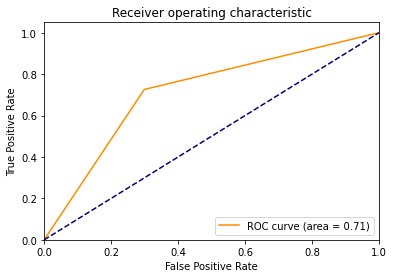

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
modeler(knn)

F1 Score: 0.821529745042493
[[152  21]
 [ 42 145]]


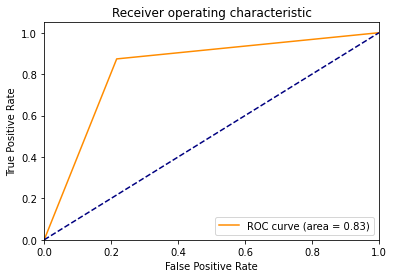

In [40]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
modeler(dt)

Best ones seem to be LGBM and XGB. Ideal ROC graph looks hugs the top left corner.

## Hyperparameter Optimization

Time to tune with Hyperopt.
(Scaling/normalizing isn't needed for gradient boosted decision trees so skip it)

# EVERYONE CAN TRY OPTIMIZING WITH DIFFERENT HYPERPARAMETERS LIKE IN THE COMMENTED OUT LINES, check the user docs for more parameters

In [41]:
# #hyperparameter domain to search over
# hyperparam_space = {
#     'num_leaves':       hp.choice('num_leaves', np.arange(30, 250, 1)),
#     'learning_rate':    hp.quniform('learning_rate', 0, 0.3, 0.01),
#     'max_depth':        hp.choice('max_depth', np.arange(2, 100, 1, dtype=int)),
#     'min_child_weight': hp.choice('min_child_weight', np.arange(1, 50, 1, dtype=int)),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1),
#     'subsample':        hp.uniform('subsample', 0.5, 1),
# }

Following code takes a couple minutes to run:

In [42]:
# def score(params): #function to train and test different hyperparams
#     model = lgb.LGBMClassifier(**params)
#     model.fit(X_train_fs, y_train, early_stopping_rounds=20,
#              eval_set=[(X_train_fs, y_train), (X_test_fs, y_test)])
# #     y_pred = model.predict(X_test_fs)
# #     score = mean_squared_error(y_test, y_pred)
#     score = -cross_val_score(model, X_train_fs, y_train, cv=10, scoring='roc_auc').mean()
#     print(score)
#     return score
            
# def optimize(trials, space): #fmin is the main library function
#     best = fmin(score, space, algo=tpe.suggest, max_evals=10)
#     return best
            
# trials = Trials() #database that store completed hyperparameters and score
# best_params = optimize(trials, hyperparam_space) #calls fmin

# #finds best hyperparameters
# # space_eval(hyperparam_space, best_params)

In [43]:
# best_params

In [44]:
# lgbm_model = lgb.LGBMClassifier(**best_params)
# lgbm_model.fit(X_train_fs, y_train)
# preds = [pred[1] for pred in lgbm_model.predict_proba(X_test_fs)]
# score = roc_auc_score(y_test, preds, average='weighted')
# print('auc_roc score: ', score)

# y_pred = lgbm_model.predict(X_test_fs)
# f1 = f1_score(y_test, y_pred) #get f1 score
# print('F1 Score:', f1)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [45]:
# shap_values = shap.TreeExplainer(lgbm_model).shap_values(X_test_fs)
# shap.summary_plot(shap_values, X_test_fs)

In [46]:
# lgb.plot_importance(lgbm_model, max_num_features=20)
# plt.figure(figsize=(25, 12))
# plt.show()

In [47]:
#hyperparameter domain to search over
hyperparam_space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 10, 1, dtype=int)), #larger values = overfitting
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, 1, dtype=int)), #larger values = overfitting
    'learning_rate': hp.quniform('learning_rate', 0, 1, 0.01), #aka eta = step size shrinkage to prevent overfitting
#     'gamma': hp.quniform('gamma', 0, 1, 0.05), #gamma: min loss reduction to partition leaf nodes (for overfitting)
#     'min_child_weight': hp.quniform('min_child_weight', 1, 8, 0.5),
#     'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
}

In [48]:
def xgb_score(params): #function to train and test different hyperparams
    model = xgb.XGBClassifier(**params, eval_metric='logloss')
    model.fit(X_train_fs, y_train, early_stopping_rounds=20,
             eval_set=[(X_train_fs, y_train), (X_test_fs, y_test)])
    score = -cross_val_score(model, X_train_fs, y_train, cv=10, scoring='roc_auc').mean()
    print(score)
    return {'loss': score, 'status': STATUS_OK}
            
def xgb_optimize(trials, space): #fmin is the main library function
    best = fmin(xgb_score, space, algo=tpe.suggest, max_evals=5)
    return best
            
trials = Trials() #database that store completed hyperparameters and score
best_xgb_params = xgb_optimize(trials, hyperparam_space) #calls fmin

[0]	validation_0-logloss:0.30518	validation_1-logloss:0.45132                                                                                          
[1]	validation_0-logloss:0.16903	validation_1-logloss:0.36883                                                                                          
[2]	validation_0-logloss:0.10070	validation_1-logloss:0.33400                                                                                          
[3]	validation_0-logloss:0.06714	validation_1-logloss:0.30098                                                                                          
[4]	validation_0-logloss:0.04779	validation_1-logloss:0.26818                                                                                          
[5]	validation_0-logloss:0.03549	validation_1-logloss:0.26500                                                                                          
[6]	validation_0-logloss:0.02796	validation_1-logloss:0.25435                           

[25]	validation_0-logloss:0.07508	validation_1-logloss:0.32421                                                                                         
[26]	validation_0-logloss:0.07037	validation_1-logloss:0.33479                                                                                         
[27]	validation_0-logloss:0.06731	validation_1-logloss:0.32762                                                                                         
[28]	validation_0-logloss:0.06402	validation_1-logloss:0.33215                                                                                         
[29]	validation_0-logloss:0.06107	validation_1-logloss:0.32368                                                                                         
[30]	validation_0-logloss:0.05817	validation_1-logloss:0.31252                                                                                         
-0.9602765890327591                                                                     

[46]	validation_0-logloss:0.06556	validation_1-logloss:0.20444                                                                                         
[47]	validation_0-logloss:0.06257	validation_1-logloss:0.20456                                                                                         
[48]	validation_0-logloss:0.06103	validation_1-logloss:0.20428                                                                                         
[49]	validation_0-logloss:0.05985	validation_1-logloss:0.20479                                                                                         
[50]	validation_0-logloss:0.05866	validation_1-logloss:0.20516                                                                                         
[51]	validation_0-logloss:0.05696	validation_1-logloss:0.20595                                                                                         
[52]	validation_0-logloss:0.05577	validation_1-logloss:0.20527                          

[99]	validation_0-logloss:0.01725	validation_1-logloss:0.18895                                                                                         
[100]	validation_0-logloss:0.01687	validation_1-logloss:0.18982                                                                                        
[101]	validation_0-logloss:0.01654	validation_1-logloss:0.19026                                                                                        
[102]	validation_0-logloss:0.01617	validation_1-logloss:0.19090                                                                                        
[103]	validation_0-logloss:0.01564	validation_1-logloss:0.19182                                                                                        
[104]	validation_0-logloss:0.01519	validation_1-logloss:0.19173                                                                                        
[105]	validation_0-logloss:0.01492	validation_1-logloss:0.19137                         

[35]	validation_0-logloss:0.15506	validation_1-logloss:0.22470                                                                                         
[36]	validation_0-logloss:0.15275	validation_1-logloss:0.22415                                                                                         
[37]	validation_0-logloss:0.15091	validation_1-logloss:0.22270                                                                                         
[38]	validation_0-logloss:0.14852	validation_1-logloss:0.21967                                                                                         
[39]	validation_0-logloss:0.14637	validation_1-logloss:0.21802                                                                                         
[40]	validation_0-logloss:0.14356	validation_1-logloss:0.21970                                                                                         
[41]	validation_0-logloss:0.14162	validation_1-logloss:0.21847                          

[88]	validation_0-logloss:0.05989	validation_1-logloss:0.20109                                                                                         
[89]	validation_0-logloss:0.05921	validation_1-logloss:0.20145                                                                                         
[90]	validation_0-logloss:0.05797	validation_1-logloss:0.20106                                                                                         
[91]	validation_0-logloss:0.05674	validation_1-logloss:0.20202                                                                                         
[92]	validation_0-logloss:0.05593	validation_1-logloss:0.20191                                                                                         
[93]	validation_0-logloss:0.05479	validation_1-logloss:0.20181                                                                                         
[94]	validation_0-logloss:0.05392	validation_1-logloss:0.20247                          

[14]	validation_0-logloss:0.22632	validation_1-logloss:0.32896                                                                                         
[15]	validation_0-logloss:0.21417	validation_1-logloss:0.31871                                                                                         
[16]	validation_0-logloss:0.20213	validation_1-logloss:0.31005                                                                                         
[17]	validation_0-logloss:0.19238	validation_1-logloss:0.30192                                                                                         
[18]	validation_0-logloss:0.18137	validation_1-logloss:0.29510                                                                                         
[19]	validation_0-logloss:0.17367	validation_1-logloss:0.28815                                                                                         
[20]	validation_0-logloss:0.16537	validation_1-logloss:0.27986                          

[67]	validation_0-logloss:0.03494	validation_1-logloss:0.19238                                                                                         
[68]	validation_0-logloss:0.03378	validation_1-logloss:0.19242                                                                                         
[69]	validation_0-logloss:0.03280	validation_1-logloss:0.19194                                                                                         
[70]	validation_0-logloss:0.03169	validation_1-logloss:0.19166                                                                                         
[71]	validation_0-logloss:0.03102	validation_1-logloss:0.19162                                                                                         
[72]	validation_0-logloss:0.03005	validation_1-logloss:0.19090                                                                                         
[73]	validation_0-logloss:0.02928	validation_1-logloss:0.19184                          

[120]	validation_0-logloss:0.01221	validation_1-logloss:0.18629                                                                                        
[121]	validation_0-logloss:0.01205	validation_1-logloss:0.18626                                                                                        
[122]	validation_0-logloss:0.01191	validation_1-logloss:0.18653                                                                                        
[123]	validation_0-logloss:0.01175	validation_1-logloss:0.18664                                                                                        
[124]	validation_0-logloss:0.01161	validation_1-logloss:0.18608                                                                                        
[125]	validation_0-logloss:0.01147	validation_1-logloss:0.18495                                                                                        
[126]	validation_0-logloss:0.01133	validation_1-logloss:0.18512                         

In [49]:
# best_xgb_params = {'learning_rate': 0.21, 'max_depth': 1, 'n_estimators': 392}
best_xgb_params

{'learning_rate': 0.11, 'max_depth': 4, 'n_estimators': 73}

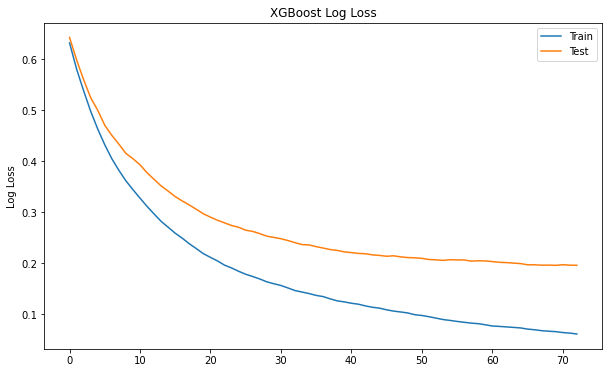

In [50]:
xgb_model = xgb.XGBClassifier(**best_xgb_params, eval_metric='logloss')
eval_set = [(X_train_fs, y_train), (X_test_fs, y_test)]

xgb_model.fit(X_train_fs, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)


results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
    
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

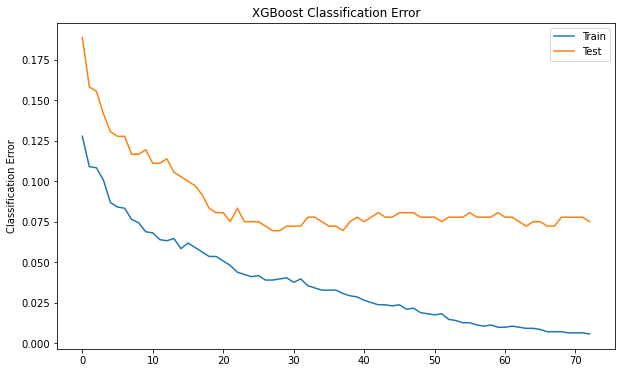

In [51]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
    
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [52]:
# xgb_model.save_model("xgb_model.txt")

## Testing on Output 

In [53]:
saved_model = xgb.Booster()
saved_model.load_model("xgb_model.txt")

In [54]:
X_test_D = xgb.DMatrix(X_test_fs)

In [55]:
y_pred = saved_model.predict(X_test_D)
f1=f1_score(y_test, (y_pred > 0.6622))
print('F1 Score:', f1)
print(confusion_matrix(y_test, (y_pred > 0.6622)))
print(classification_report(y_test, (y_pred > 0.6622)))

F1 Score: 0.948509485094851
[[166   7]
 [ 12 175]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       173
           1       0.96      0.94      0.95       187

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



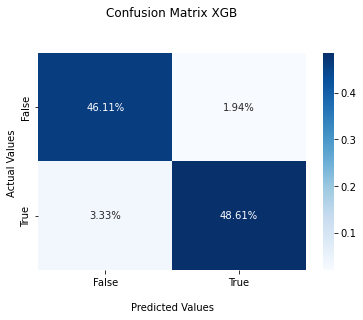

In [56]:
cf_matrix = confusion_matrix(y_test, (y_pred > 0.6622))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix XGB\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [57]:
def get_fpr(y_true, y_pred):
    nbenign = (y_true == 0).sum()
    nfalse = (y_pred[y_true == 0] == 1).sum()
    return nfalse / float(nbenign)


def find_threshold(y_true, y_pred, fpr_target):
    thresh = 0.0
    fpr = get_fpr(y_true, y_pred > thresh)
    while fpr > fpr_target and thresh < 1.0:
        thresh += 0.0001
        fpr = get_fpr(y_true, y_pred > thresh)
    return thresh, fpr

# testdf = emberdf[emberdf["subset"] == "test"]
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print()

threshold, fpr = find_threshold(y_test, y_pred, 0.01)
fnr = (y_pred[y_test == 1] < threshold).sum() / float((y_test == 1).sum())
print("XGB Model Performance at 1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))
print()

threshold, fpr = find_threshold(y_test, y_pred, 0.001)
fnr = (y_pred[y_test == 1] < threshold).sum() / float((y_test == 1).sum())
print("XGB Model Performance at 0.1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))

ROC AUC: 0.9862446292232079

XGB Model Performance at 1% FPR:
Threshold: 0.8086
False Positive Rate: 0.578%
False Negative Rate: 13.369%
Detection Rate: 86.63101604278074%

XGB Model Performance at 0.1% FPR:
Threshold: 0.9888
False Positive Rate: 0.000%
False Negative Rate: 78.610%
Detection Rate: 21.390374331550802%


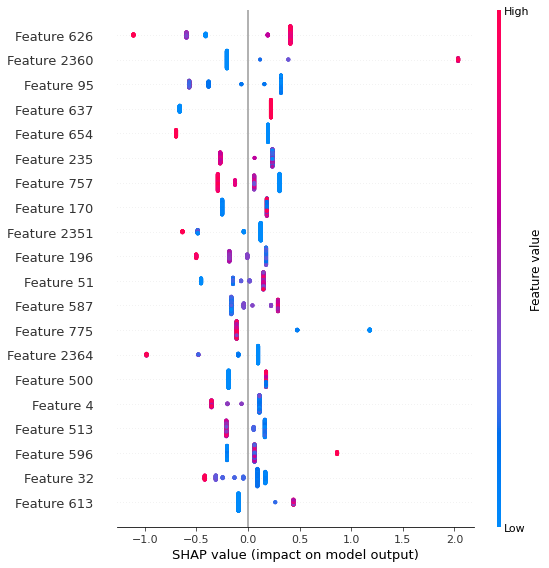

In [58]:
shap_values = shap.TreeExplainer(saved_model).shap_values(X_test_fs)
shap.summary_plot(shap_values, X_test_fs)

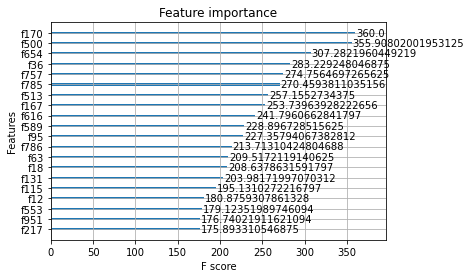

<Figure size 1800x864 with 0 Axes>

In [59]:
xgb.plot_importance(saved_model, importance_type='cover', max_num_features=20)
plt.figure(figsize=(25, 12))
plt.show()

## Conclusions

## Visualizations should include the above ROC plots, SHAP plots, as well as the built in feature importance plots.

# scrap the below in final version

### Anomaly Detection Approach??

In [60]:
df1.shape #go back to original dataset

(18000, 714)

In [61]:
df1 = df1._get_numeric_data() #drop nonnumeric columns

#### Isolation Forest

Setting contamination rate to 5% as seen in original data, using 200 estimators.

In [62]:
iso = IsolationForest(n_estimators=200, max_samples='auto', contamination=0.05)
new_df = df1.drop(columns=['category'])
iso.fit(new_df)
new_df['anomaly_score'] = iso.predict(new_df)
new_df[new_df['anomaly_score'] == -1].shape

(900, 694)

As expected, found 900 "outliers" (in our case malware).

In [63]:
iso_df = pd.concat([new_df, df1['category']], axis=1) #join the anomaly prediction with og data
iso_df.head(10)

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,...,datadirectories_12_size,datadirectories_12_virtual_address,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_size,datadirectories_15_virtual_address,anomaly_score,category
0,127242,9185,3818,3127,13300,1594,1781,1493,9938,1006,...,620,11711244,0,0,0,0,0,0,1,0
1,36152,2617,4120,876,1711,755,672,521,2278,325,...,340,131072,0,0,0,0,0,0,1,0
2,39986,7112,7953,6604,6542,6441,5869,6422,6224,6017,...,588,123728,0,0,0,0,0,0,1,0
3,253873,32714,22629,17500,15355,6691,10881,4258,11992,3513,...,216,282920,0,0,0,0,0,0,1,0
4,12464,1020,502,264,1918,218,262,91,846,78,...,0,0,0,0,0,0,0,0,1,0
5,17889,1281,868,642,914,138,311,148,433,82,...,0,0,0,0,0,0,0,0,1,0
6,224255,28215,12691,13046,21264,4115,3790,3590,11766,1889,...,408,1188328,0,0,0,0,0,0,1,0
7,14195,1054,778,1068,291,653,251,249,338,164,...,0,0,0,0,0,0,0,0,1,0
8,48208,3288,1441,2611,4938,313,266,635,2104,231,...,1284,230880,0,0,0,0,0,0,1,0
9,370224,37570,24575,18127,40687,15614,12405,11777,24099,5331,...,0,0,0,0,0,0,0,0,1,0


In [64]:
iso_df.groupby('anomaly_score').size() #sanity check

anomaly_score
-1      900
 1    17100
dtype: int64

In [65]:
iso_df['anomaly'] = "" #add new empty column to switch out -1 to 1 and 1 to 0

In [66]:
iso_df.loc[iso_df.anomaly_score == -1, "anomaly"] = 1
iso_df.loc[iso_df.anomaly_score == 1, "anomaly"] = 0

In [67]:
print(iso_df.groupby('anomaly').size(), iso_df.groupby('category').size())

anomaly
0    17100
1      900
dtype: int64 category
0    17100
1      900
dtype: int64


In [68]:
iso_df.head(5)

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,...,datadirectories_12_virtual_address,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_size,datadirectories_15_virtual_address,anomaly_score,category,anomaly
0,127242,9185,3818,3127,13300,1594,1781,1493,9938,1006,...,11711244,0,0,0,0,0,0,1,0,0
1,36152,2617,4120,876,1711,755,672,521,2278,325,...,131072,0,0,0,0,0,0,1,0,0
2,39986,7112,7953,6604,6542,6441,5869,6422,6224,6017,...,123728,0,0,0,0,0,0,1,0,0
3,253873,32714,22629,17500,15355,6691,10881,4258,11992,3513,...,282920,0,0,0,0,0,0,1,0,0
4,12464,1020,502,264,1918,218,262,91,846,78,...,0,0,0,0,0,0,0,1,0,0


Calculate f1 score between new anomaly column and given category column.

In [69]:
f1_score(list(iso_df['category']), list(iso_df['anomaly']))

0.011111111111111112

### what happened???